In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import sys

#motorstroom = pd.read_excel('data/Switch01_Data.xlsx', sheet_name=2, usecols=[6, 7])
#motorstroom.to_pickle('switch01_motorstroom.pickle')
motorstroom = pd.read_pickle('switch01_motorstroom.pickle')

# controle_links = pd.read_excel('data/Switch01_Data.xlsx', sheet_name=2, usecols=[0, 1])
# controle_links.to_pickle('switch01_controle_links.pickle')
controle_links = pd.read_pickle('switch01_controle_links.pickle')

# controle_rechts = pd.read_excel('data/Switch01_Data.xlsx', sheet_name=2, usecols=[3, 4])
# controle_rechts.to_pickle('switch01_controle_rechts.pickle')
controle_rechts = pd.read_pickle('switch01_controle_rechts.pickle')

#sturing_links = pd.read_excel('data/Switch01_Data.xlsx', sheet_name=2, usecols=[9, 10])
#sturing_links.to_pickle('switch01_sturing_links.pickle')
sturing_links = pd.read_pickle('switch01_sturing_links.pickle')

#sturing_rechts = pd.read_excel('data/Switch01_Data.xlsx', sheet_name=2, usecols=[12, 13])
#sturing_rechts.to_pickle('switch01_sturing_rechts.pickle')
sturing_rechts = pd.read_pickle('switch01_sturing_rechts.pickle')

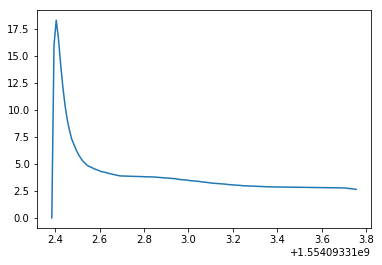

In [6]:
# quick sanity check

N = 50

plt.figure()
plt.plot([t.timestamp() for t in motorstroom.values[:N, 0]], motorstroom.values[:N, 1])
plt.show()

In [7]:
# detect individual switching events

events = []
last_begin = None

row_l = 0
row_r = 0

while row_l < len(sturing_links) and row_r < len(sturing_links) \
        and row_l < 20:  # cut it off becaus everything is slow af
    # compare next timestamps of both
    ts_l = sturing_links.values[row_l,0]
    ts_r = sturing_rechts.values[row_r,0]
    print(ts_l, ts_r, row_l, row_r)

    if ts_l < ts_r:
        # did it actually change?
        if row_l > 0 and sturing_links.values[row_l,1] != sturing_links.values[row_l - 1,1]:
            # yay!
            events += [(ts_l, 'LEFT', sturing_links.values[row_l, 1])]
        row_l += 1
    else:
        # did it actually change?
        if row_r > 0 and sturing_rechts.values[row_r,1] != sturing_rechts.values[row_r - 1,1]:
            # yay!
            events += [(ts_r, 'RIGHT', sturing_links.values[row_r, 1])]
        row_r += 1

events

2019-04-01 00:00:00.014000 2019-04-01 00:00:00.014000
0 1
2019-04-01 00:00:00.014000 2019-04-01 00:30:00.029000
1 1
2019-04-01 00:30:00.029000 2019-04-01 00:30:00.029000
1 2
2019-04-01 00:30:00.029000 2019-04-01 01:00:00.048000
2 2
2019-04-01 01:00:00.048000 2019-04-01 01:00:00.048000
2 3
2019-04-01 01:00:00.048000 2019-04-01 01:29:59.963000
3 3
2019-04-01 01:29:59.963000 2019-04-01 01:29:59.963000
3 4
2019-04-01 01:29:59.963000 2019-04-01 01:59:59.981000
4 4
2019-04-01 01:59:59.981000 2019-04-01 01:59:59.981000
4 5
2019-04-01 01:59:59.981000 2019-04-01 02:29:59.997000
5 5
2019-04-01 02:29:59.997000 2019-04-01 02:29:59.997000
5 6
2019-04-01 02:29:59.997000 2019-04-01 03:00:00.013000
6 6
2019-04-01 03:00:00.013000 2019-04-01 03:00:00.013000
6 7
2019-04-01 03:00:00.013000 2019-04-01 03:30:00.029000
7 7
2019-04-01 03:30:00.029000 2019-04-01 03:30:00.029000
7 8
2019-04-01 03:30:00.029000 2019-04-01 04:00:00.046000
8 8
2019-04-01 04:00:00.046000 2019-04-01 04:00:00.046000
8 9
2019-04-01 04:

[(Timestamp('2019-04-01 04:35:12.362000'), 'LEFT', 1.0),
 (Timestamp('2019-04-01 04:35:15.212000'), 'LEFT', 0.0),
 (Timestamp('2019-04-01 04:43:32.921000'), 'RIGHT', 1.0),
 (Timestamp('2019-04-01 04:43:35.771000'), 'RIGHT', 0.0),
 (Timestamp('2019-04-01 05:00:56.079000'), 'RIGHT', 0.0),
 (Timestamp('2019-04-01 05:00:58.929000'), 'RIGHT', 1.0),
 (Timestamp('2019-04-01 05:05:10.378000'), 'LEFT', 1.0),
 (Timestamp('2019-04-01 05:05:13.178000'), 'LEFT', 0.0),
 (Timestamp('2019-04-01 05:14:55.036000'), 'RIGHT', 0.0),
 (Timestamp('2019-04-01 05:14:57.836000'), 'RIGHT', 1.0),
 (Timestamp('2019-04-01 05:27:09.846000'), 'LEFT', 1.0),
 (Timestamp('2019-04-01 05:27:12.646000'), 'LEFT', 0.0),
 (Timestamp('2019-04-01 05:35:21.395000'), 'RIGHT', 0.0),
 (Timestamp('2019-04-01 05:35:24.195000'), 'RIGHT', 1.0),
 (Timestamp('2019-04-01 05:37:45.544000'), 'LEFT', 1.0)]

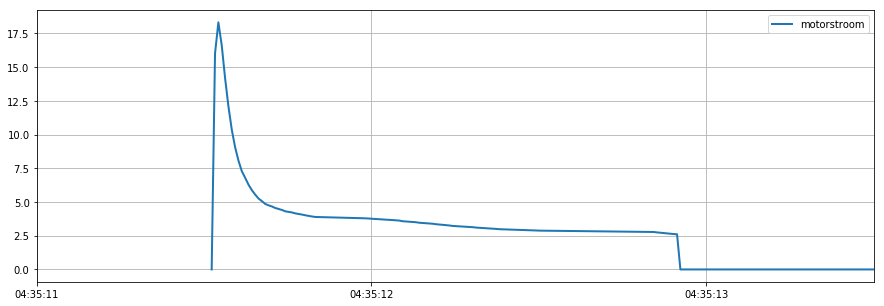

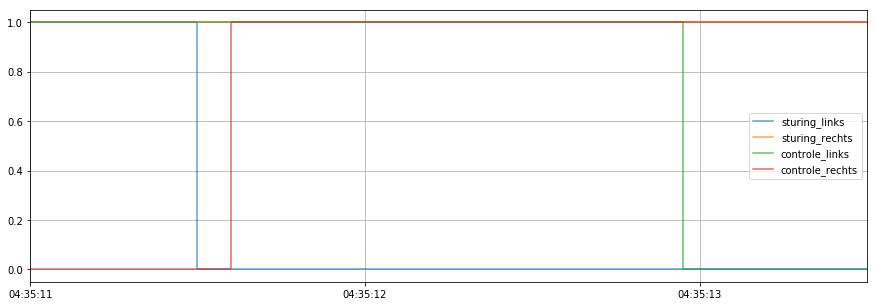

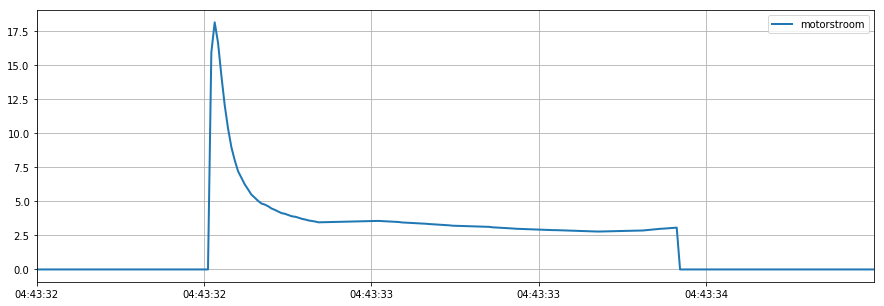

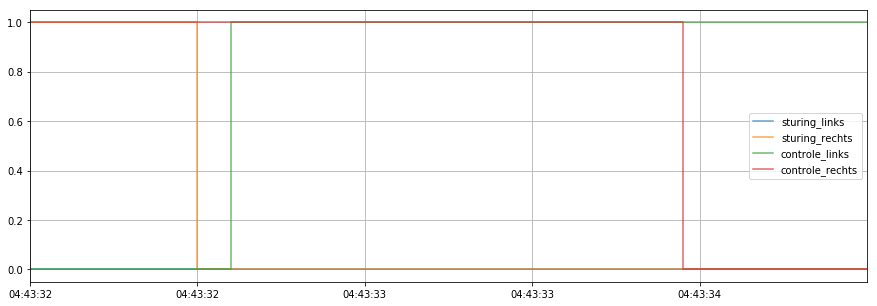

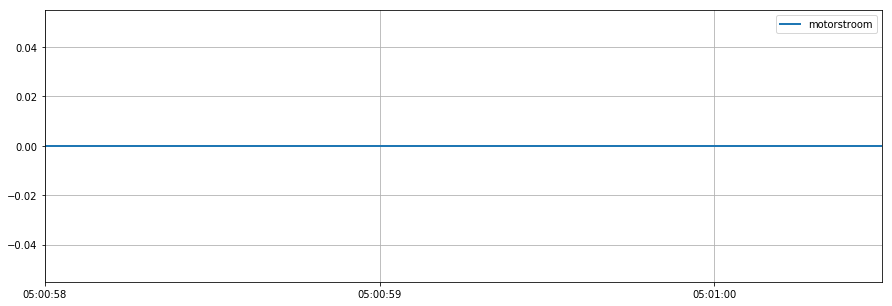

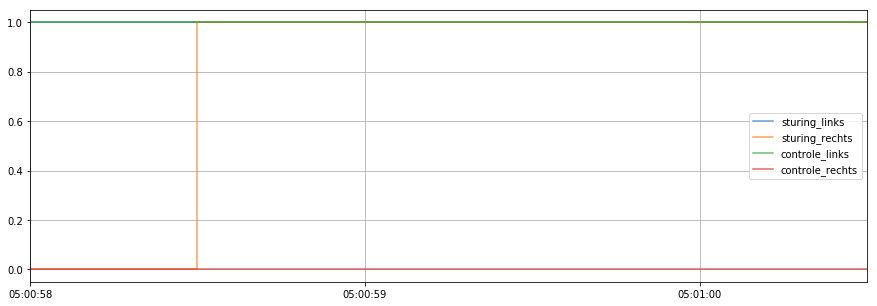

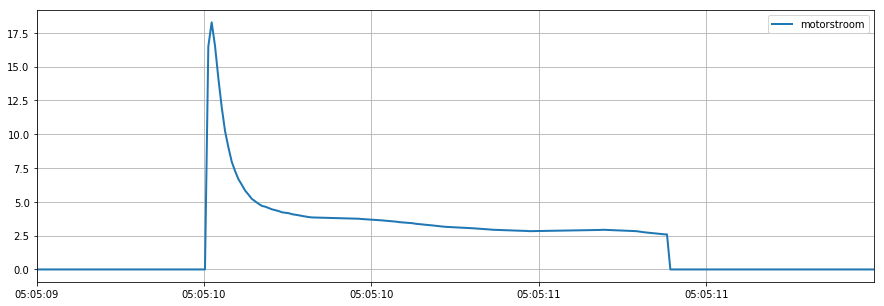

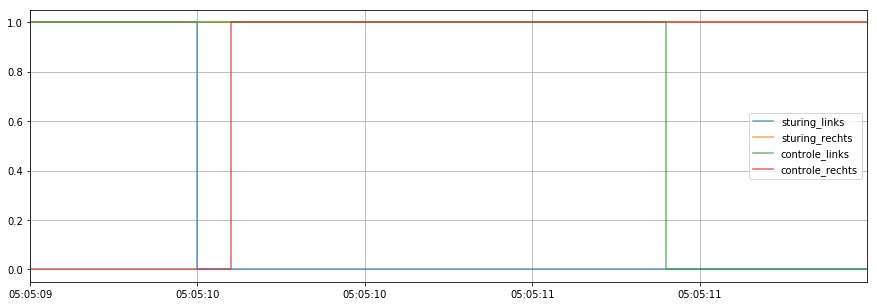

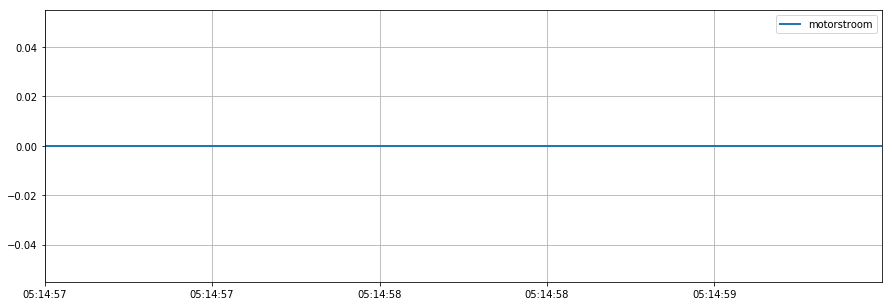

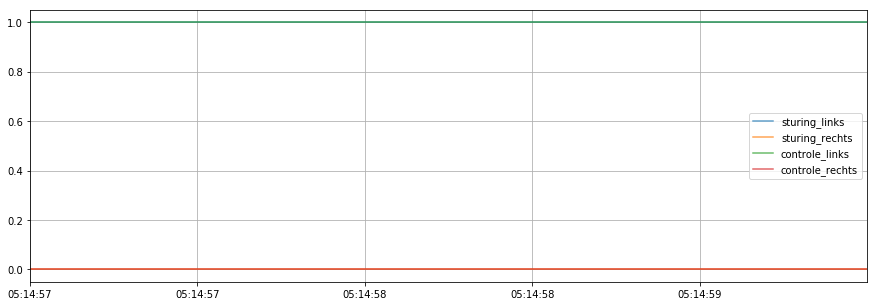

In [21]:
import datetime

def data_for_period(table, start, end):
    start_index = max(0, table[table.values[:,0] > start].first_valid_index() - 1)
    #start_index = table[table.index > start].first_valid_index()
    #end_index = table[table.index >= end].first_valid_index()
    end_index = table[table.values[:,0] >= end].first_valid_index() + 1

    return table[start_index:end_index]

def visualize_event(starttime_in):
    starttime = starttime_in - datetime.timedelta(seconds=0.5)
    endtime = starttime_in + datetime.timedelta(seconds=2)

    #print('Timespan: ', motorstroom_period.values[-1,0] - motorstroom_period.values[0,0])
    plt.figure(figsize=(15, 5))

    motorstroom_period = data_for_period(motorstroom, starttime, endtime)
    plt.plot(motorstroom_period.values[:,0], motorstroom_period.values[:,1], label='motorstroom', linewidth=2)

    plt.grid(which='both')
    plt.legend()
    plt.xlim([starttime, endtime])
    
    plt.figure(figsize=(15, 5))

    sturing_links_period = data_for_period(sturing_links, starttime, endtime)
    plt.step(sturing_links_period.values[:,0], sturing_links_period.values[:,1], alpha=0.7, label='sturing_links')

    sturing_rechts_period = data_for_period(sturing_rechts, starttime, endtime)
    plt.step(sturing_rechts_period.values[:,0], sturing_rechts_period.values[:,1], alpha=0.7, label='sturing_rechts')

    controle_links_period = data_for_period(controle_links, starttime, endtime)
    plt.step(controle_links_period.values[:,0], controle_links_period.values[:,1], alpha=0.7, label='controle_links')

    controle_rechts_period = data_for_period(controle_rechts, starttime, endtime)
    plt.step(controle_rechts_period.values[:,0], controle_rechts_period.values[:,1], alpha=0.7, label='controle_rechts')

    plt.grid(which='both')
    plt.legend()
    plt.xlim([starttime, endtime])

for when, what, val in events[0:10]:
    if val > 0.5:
        visualize_event(when)